# Preprocessing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Function for loading the Dataset.

In [ ]:
import numpy as np
from urllib.request import urlopen

def load_fashion_mnist():

    url_base = "https://www.math.unipd.it/~dasan/"
    Y_train = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_train = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_train), 784) 
                                                                                            
    Y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_test), 784)

    return X_train, Y_train, X_test, Y_test

X_train_val, Y_train_val, X_test, Y_test = load_fashion_mnist()


First of all let's have a look of the data. The images are already in grey-scale since every pixel has just one number.

In [ ]:
import matplotlib.pyplot as plt 
from collections import Counter

print(X_train_val.shape, Y_train_val.shape, X_test.shape, Y_test.shape) #shape of the data
#value of the data
print(f"Min: {X_train_val[0].min()}")
print(f"Max: {X_train_val[0].max()}")
print(f"Mean: {X_train_val[0].mean():.5f}")
print(f"Min: {X_train_val[10].min()}")
print(f"Max: {X_train_val[10].max()}")
print(f"Mean: {X_train_val[10].mean():.5f}")
#grayscale goes from 0 to 255

#what are our images
labels_name={
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot'
}


print(Counter(Y_train_val)) #classes are perfectly balanced

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(30, 9)) #data displayed
for ax, x, label in zip(axes,X_train_val[0:10], Y_train_val[0:10]):
  ax.set_axis_off()
  X_image=x.reshape(28,28)
  ax.imshow(X_image, cmap=plt.cm.gray_r, interpolation="nearest")
  ax.set_title("Training: %s" % labels_name[label])

Data are perfectly balanced, so far as I know I won't need Under or Over Sampling methods.

I build the validation and the training set.

In [ ]:
from sklearn.model_selection import train_test_split
# we prefer a small validation set since dataset is quite big
X_train, X_val, y_train, y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, shuffle=False)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(Counter(y_train))
#data are still balanced

Now I build several type of training set and validation set:
- two set preprocessed by MinMax scaler and Standard Scaler,
- one set with a smaller size for classifiers that do not run in a reasonable time with the whole batch of data,

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#training and validation sets rescaled in 0-1 values 
minmax_scal=MinMaxScaler().fit(X_train_val)
X_train_mm=minmax_scal.transform(X_train)
X_val_mm=minmax_scal.transform(X_val)
# this means X_train_mm=X_train/255

#training and validation sets rescaled with 0 mean 1 std
stand_scal=StandardScaler().fit(X_train_val)
X_train_ss=stand_scal.transform(X_train)
X_val_ss=stand_scal.transform(X_val)


In [ ]:
#smaller data sets
X_train_small, X_val_small, y_train_small, y_val_small = train_test_split(X_val, y_val, test_size=0.1, shuffle=False)
print(X_train_small.shape, y_train_small.shape, X_val_small.shape, y_val_small.shape)
print(Counter(y_train_small))

#data more or less balanced

# Support Vector Machine. 

SVM can run only with small data set, training on the all data takes 3 minutes and make a prediction on the training set takes 14 minutes. For this reason I prefer to avoid to make a prediction for the training set, computing the accuracy score only for the validation set. (Uncomment the cell of the training set to see its accuracy score)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm

#parameters
svc_grid_params = {
    'C': ( 1, 10, 100),
    'kernel': ('rbf', 'linear'),
}

#grid search object
model = svm.SVC(random_state = 123)
clf_4 = GridSearchCV(estimator = model,
                     param_grid = svc_grid_params, 
                     scoring='accuracy',
                     n_jobs= -1, cv = 5, verbose = 1)

#training 
clf_4.fit(X_train_small,y_train_small)


print(clf_4.best_params_)
print(clf_4.best_score_)

#expected output:
#Fitting 5 folds for each of 6 candidates, totalling 30 fits
#{'C': 100, 'kernel': 'rbf'}
#0.8585185185185186

In [ ]:
#model definition with best parameters
clf_svm=svm.SVC(random_state = 123,
                kernel = 'rbf',
                C=100)

#training 
clf_svm.fit(X_train,y_train)

#make a prediction for the validation set
y_pred_svm_val=clf_svm.predict(X_val) 
print(f"accuracy score SVM on validation set: \t{accuracy_score(y_val,y_pred_svm_val):.5f}")

#expected output:
#accuracy score SVM on validation set: 	0.89183

In [ ]:
"""
y_pred_svm_train=clf_svm.predict(X_train) 
print(f"accuracy score SVM on trainin set: \t{accuracy_score(y_train,y_pred_svm_train):.5f}")
"""

#expected output
#accuracy score SVM on trainin set: 	0.99969

## What happen with scaled data?

The best accuracy score is reached using the Standard Scaled data and is not so better than the accuracy score just gained. 
Uncomment the other lines to see what happen with MinMax scaler and hog transformation.

In [ ]:
#minmax scaler

"""
#model
clf_svm_mm=svm.SVC(random_state = 123,
                kernel = 'rbf',
                C=100)

#training 
clf_svm_mm.fit(X_train_mm,y_train)

#make a prediction for the validation set
y_pred_svm_val=clf_svm_mm.predict(X_val_mm) 
print(f"accuracy score SVM  with MinMax scaler data on val: \t{accuracy_score(y_val,y_pred_svm_val):.5f}")
"""

#Standard scaler

#model
clf_svm_ss=svm.SVC(random_state = 123,
                kernel = 'rbf',
                C=100)

#training 
clf_svm_ss.fit(X_train_ss,y_train)

#make a prediction for the validation set
y_pred_svm_val=clf_svm_ss.predict(X_val_ss) 
print(f"accuracy score SVM  with Standardscaler data on val: \t{accuracy_score(y_val,y_pred_svm_val):.5f}")


"""
#Hog transformed data

#model
clf_svm_hog=svm.SVC(random_state = 123,
                kernel = 'rbf',
                C=100)

#training 
clf_svm_hog.fit(X_train_hog,y_train_small)

#We can make prediction on both train and val because we are using small data set
y_pred_svm_train=clf_svm_hog.predict(X_train_hog)
y_pred_svm_val=clf_svm_hog.predict(X_val_hog) 
print(f"accuracy score SVM  with Hog transformed data on train: \t{accuracy_score(y_train_small,y_pred_svm_train):.5f}, val: \t{accuracy_score(y_val_small,y_pred_svm_val):.5f}")
"""


#questi score sono falsati perchè il validation è calcolato su un set che 
#expected output:
#accuracy score SVM  with MinMax scaler data on val: 	0.89167
#accuracy score SVM  with Standardscaler data on val: 	0.89350
#accuracy score SVM  with Hog trnasformed data on train: 	1.00000, val: 	0.84333

# Artificial Neural Network

In Keras documentation we can read that "images need to be read and decoded into integer tensors, then converted to floating point and normalized to small values (usually between 0 and 1)".

For this reason in the ANN implementation I use only data preprocessed by MinMax scaler and Standard Scaler.

First of all I implement a function that allows me to make e grid search for the optimal parameters.

In [ ]:
#libraries I need
import tensorflow
import numpy as np
import tensorflow 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.utils import to_categorical 
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

In [ ]:
#function for define and train more NN
def MLP(X,y,vector_units,n_epochs,stop,n_patience):
    #X already scaled
    #y not transformed by to_categorical
    
    #processing data
    features=np.shape(X)[1] #the input size
    num_classes=len(set(y))
    np.random.seed(123)
    set_random_seed(2)

    model=Sequential()
    n_layers=len(vector_units) #we consider only the hidden layer
    if n_layers==0:
      model.add(Dense(input_dim=features, 
                      units = num_classes, 
                      activation= 'softmax'))
    else:
      for i in range(n_layers):
        if i==0:
          model.add(Dense(input_dim=features,
                          units=vector_units[0],
                          activation='relu'))
        else: 
          model.add(Dense(units=vector_units[i],
                          activation='relu'))
      model.add(Dense(units = num_classes, 
                      activation= 'softmax'))
    
    #configure the model
    model.compile(loss='categorical_crossentropy', 
                optimizer='sgd', 
                metrics=['accuracy']) 
    
    #EarlyStopping
    if stop=='True':
      stop_er=EarlyStopping(monitor='val_loss', #quantity to be monitored
                    mode='min', #we look for decreasing patterns stop 
                    patience = n_patience, #number of epochs with no improvements
                    verbose=1)
    else:
      stop_er=None
    #training
    y=to_categorical(y,num_classes)
    train=model.fit(X,y,epochs=n_epochs,
                    batch_size=32, 
                    verbose=0,
                    validation_split=0.1,
                    callbacks=stop_er)
    
    return model,train

I create two smaller data sets of scaled data and the one-hot encoding of the labels.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#smaller data set for the grid search
minmax_scal=MinMaxScaler().fit(X_train_small)
X_train_mms=minmax_scal.transform(X_train_small) 
X_val_mms=minmax_scal.transform(X_val_small) 

#second smaller dataset for a comparison
standard_scal=StandardScaler().fit(X_train_small)
X_train_sss=standard_scal.transform(X_train_small) 
X_val_sss=standard_scal.transform(X_val_small) 

#one hot encoding
y_train_cs=to_categorical(y_train_small,10)
y_val_cs=to_categorical(y_val_small,10)


Now I can train several NN to find the best parameters.
Even though I used smaller data set this cell requires 15 or more minutes to run. Since this is actually the best model among the others it's worth it.

In [ ]:
#parameters of the function

#to avoid a 50 minutes run I put a shortes version of vector_units_list but the results is the same
# vector_units_list=[[784],[784,10],[500,200],[784,100,50],[784,200,50,10]] #long research
vector_units_list=[[784],[784,10]]
n_epochs_list=[100,500]
n_patience_list=[5,15,25]
stop='True'
#let save the maximum accuracy
acc=0
accuracy_test=[]
i=0
#grid-search
for n_epochs in n_epochs_list:
  for vector in vector_units_list:
    for n_patience in n_patience_list:

      #train a NN 
      m,t=MLP(X_train_mms,y_train_small,vector,n_epochs,stop,n_patience)
      print(i)
      i+=1
      #save the greater accuracy
      accuracy_val=m.evaluate(X_val_mms,y_val_cs,verbose=0)[1]
      if accuracy_val>acc:
        acc=accuracy_val
        win=[vector,n_epochs,n_patience]
        model=m
        accuracy_test.append(accuracy_val)

print('\n\n\n')
print(model.summary())
print('best parameters: ',win)
plt.plot(accuracy_test)
plt.title(f"accuracy growing")
plt.ylabel('accuracy')
plt.xlabel('grid search')
plt.legend(['test acc'], loc='upper left')
plt.show()

#expected output:
# best parameters: [[784], 100, 15]

Now I can train on the whole batch of data one Artificial Neural Network with the best parameters found.

In [ ]:
#runtime= ~10 minutes

#early stopping
stop=EarlyStopping(monitor='val_loss', #quantity to be monitored
                    mode='min', #we look for decreasing patterns stop 
                    patience = 15, #number of epochs with no improvements
                    verbose = 1)
#data
features=np.shape(X_train)[1]
num_classes=10 
y_train_cat=to_categorical(y_train,num_classes)
y_val_cat=to_categorical(y_val,num_classes)


#model defining
np.random.seed(123)
set_random_seed=2

nn=Sequential()
nn.add(Dense(input_dim=features,
             units=features,
             activation='relu'))
nn.add(Dense(num_classes,
             activation='softmax'))
print(nn.summary())

#compiling and training
nn.compile(loss='categorical_crossentropy',
           optimizer='sgd',
           metrics=['accuracy'])
train=nn.fit(X_train_mm,y_train_cat,
             batch_size=32,
             verbose=0,
             callbacks=stop,
             epochs=100,
             validation_split=0.1)


In [ ]:
#display the accuracy 
plt.plot(train.history['accuracy'])
plt.plot(train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation split'],loc='down right',fontsize='x-large')
plt.show()

#make prediction on training and validation set
y_pred_nn_train=nn.predict(X_train_mm).argmax(axis = 1) 
y_pred_nn_val=nn.predict(X_val_mm).argmax(axis = 1) 
print('minmax')
print(f'acc on train set: {accuracy_score(y_train,y_pred_nn_train):.5f}, acc on validation set:{accuracy_score(y_val,y_pred_nn_val):.5f}')


#expected output:
#minmax
#acc on train set: 0.94765, acc on validation set:0.89083


## What happen with Standard Scaler?

Now I another ANN using the data preprocessed by the standard scaler. The accuracy score reached on the validation is a little better then the one reached before.

In [ ]:
#early stopping
stop=EarlyStopping(monitor='val_loss', #quantity to be monitored
                    mode='min', #we look for decreasing patterns stop 
                    patience = 15, #number of epochs with no improvements
                    verbose = 1)

#model defining
np.random.seed(123)
set_random_seed=2

nns=Sequential()
nns.add(Dense(input_dim=features,
             units=features,
             activation='relu'))
nns.add(Dense(num_classes,
             activation='softmax'))
print(nns.summary())

#compiling and training
nns.compile(loss='categorical_crossentropy',
           optimizer='sgd',
           metrics=['accuracy'])
train_s=nns.fit(X_train_ss,y_train_cat,
             batch_size=16,
             verbose=0,
             callbacks=stop,
             epochs=100,
             validation_split=0.1)


#display the accuracy 
plt.plot(train_s.history['accuracy'])
plt.plot(train_s.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation split'],loc='down right',fontsize='x-large')
plt.show()

#make prediction on training and validation set
y_pred_train_ss=nns.predict(X_train_ss).argmax(axis = 1) 
y_pred_val_ss=nns.predict(X_val_ss).argmax(axis = 1) 
print('Standard Scaler')
print(f'acc on train set: {accuracy_score(y_train,y_pred_train_ss):.5f}, acc on validation set:{accuracy_score(y_val,y_pred_val_ss):.5f}')


#expected output:
#Standard Scaler
#acc on train set: 0.97587, acc on validation set:0.89417

# Convolutional Neural Network (Pytorch)

In [ ]:
# install for colab
!pip install torch torchvision torchaudio
!pip install pytorch-lightning
!pip install torchmetrics

# windows - conda - cpu
# !conda install pytorch torchvision torchaudio cpuonly -c pytorch
# !conda install -c conda-forge pytorch-lightning
# !conda install -c conda-forge torchmetrics

In [39]:
# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import Callback
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
from pytorch_lightning.callbacks.early_stopping import EarlyStopping 


import matplotlib.pyplot as plt
import numpy as np

## Dataset and Dataloaders

In [40]:
### Dataset

dataset = datasets.FashionMNIST('FashionMNIST', train = True, download = True,
                             transform = transforms.Compose([
                               transforms.ToTensor(),
                                transforms.Normalize(0.0, 1.0, inplace=True),
                                 transforms.RandomAffine(10, (0.1,0.1), (0.95,1)),
                                 transforms.RandomCrop((28,28))
                             ]))

test_data = datasets.FashionMNIST('FashionMNIST', train = False, download = True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                                 transforms.Normalize(0.0, 1.0, inplace=True)
                             ]))

# Divide data dataset in train dataset and val dataset
train_data, val_data = torch.utils.data.random_split(dataset, [50000, 10000])

In [41]:
### Dataloaders
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle=True, num_workers=0)

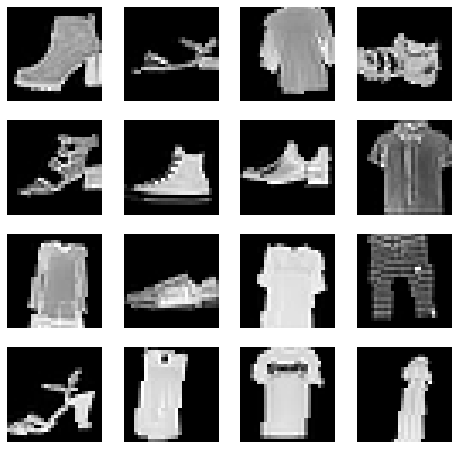

In [42]:
# Plot some samples
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(1,cols * rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Define the model

In [54]:
class ConvNet(pl.LightningModule):
    
    def __init__(self, activation, drop_p, lr=0.001):
        """
        The input is typically a MNIST images batch, encoded in a torch.tensor of size (N,1,28,28), where N is the batch size
        -----------
        Parameters:
        act = activation function 
        drop_p = dropout probability
        """
        super().__init__()
        
        # Parameters 
        self.act = getattr(nn, activation)(inplace = True)
        self.drop_p = drop_p
        self.lr = lr
        self.accuracy = torchmetrics.Accuracy()
        
        
        ## Network architecture
        # Convolution part
        self.cnn = nn.Sequential(
            #first convolution layer
            nn.Conv2d(1, 16, 5),  # out = (N, 16, 24, 24)
            nn.BatchNorm2d(16),
            self.act,
            nn.Dropout(self.drop_p, inplace = False),
            nn.MaxPool2d(2),  # out = (N, 16, 12, 12)
            # Second convolution layer
            nn.Conv2d(16, 32, 5), # out = (N, 32, 8, 8)
            nn.BatchNorm2d(32),
            self.act,
            nn.Dropout(self.drop_p, inplace = False),
            nn.MaxPool2d(2) # out = (N, 32, 4, 4)
        )
    
        # Linear classifier
        self.lin = nn.Sequential(
            nn.Linear(in_features = 32*4*4, out_features = 128),
            nn.BatchNorm1d(128),
            self.act,
            nn.Dropout(self.drop_p, inplace = False),
            nn.Linear(in_features = 128, out_features = 10)
        )

        print("CNN initialized")
        
    def forward(self, x):
        # Convolution layer
        x = self.cnn(x)
        # Flatten layer
        x = torch.flatten(x, start_dim = 1)
        # Linear layer
        x = self.lin(x)
        return x
    
    
        
    def training_step(self, batch, batch_idx):
        # take data and labels
        x_batch, labels = batch
        
        # Forward pass
        y_hat = net(x_batch)
        
        # Compute loss
        train_loss = nn.CrossEntropyLoss()(y_hat, labels)
        
        # compute training accuracy
        self.accuracy(y_hat, labels)
        
        # Logging to TensorBoard by default
        self.log("train_loss", train_loss, prog_bar=True)
        self.log('train_acc', self.accuracy)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        # take data and labels
        x_batch, labels = batch
        
        # Forward pass
        y_hat = net(x_batch)
        
        # Compute loss
        val_loss = nn.CrossEntropyLoss()(y_hat, labels)
        
        # compute validation accuracy
        self.accuracy(y_hat, labels)
        
        # Logging to TensorBoard by default
        self.log("val_loss", val_loss, prog_bar=True)
        self.log('val_acc', self.accuracy)
        
        return val_loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.lr)
        return optimizer

In [55]:
# trainer callback
class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.train_loss_log = []
        self.val_loss_log = []
        self.train_acc_log= []
        self.val_acc_log= []
        
        
    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.logged_metrics["train_loss"].cpu()
        self.train_loss_log.append(train_loss)
        train_acc = trainer.logged_metrics["train_acc"].cpu()   
        self.train_acc_log.append(train_acc)
        
    def on_validation_epoch_end(self,trainer, pl_module):
        val_loss = trainer.logged_metrics["val_loss"].cpu()
        self.val_loss_log.append(val_loss)
        val_acc = trainer.logged_metrics["val_acc"].cpu()   
        self.val_acc_log.append(val_acc)
    

## Training

In [56]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [57]:
# Inizialize the network
torch.manual_seed(0)
net = ConvNet(activation="ReLU", drop_p=0.3)


# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

CNN initialized


In [58]:
# training
trainer = pl.Trainer(max_epochs=5, callbacks=[metrics_callback, early_stopping], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | act      | ReLU       | 0     
1 | accuracy | Accuracy   | 0     
2 | cnn      | Sequential | 13.3 K
3 | lin      | Sequential | 67.2 K
----------------------------------------
80.6 K    Trainable params
0         Non-trainable params
80.6 K    Total params
0.322     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

5 6
trained epochs: 5


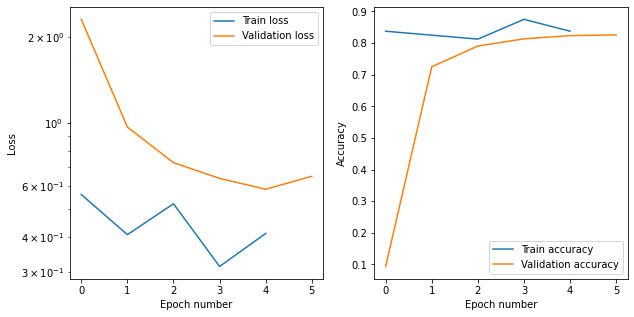

In [62]:
### Plot losses
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].semilogy(metrics_callback.train_loss_log, label="Train loss")
ax[0].semilogy(metrics_callback.val_loss_log, label="Validation loss")
ax[0].set_xlabel("Epoch number")
ax[0].set_ylabel("Loss")
ax[0].legend()

print(len(metrics_callback.train_loss_log), len(metrics_callback.val_loss_log))
ax[1].plot(metrics_callback.train_acc_log, label="Train accuracy")
ax[1].plot(metrics_callback.val_acc_log, label="Validation accuracy")
ax[1].set_xlabel("Epoch number")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
print("trained epochs: "+str(len(metrics_callback.train_loss_log)))

# Conclusion

I can finally watch the performance on the test set using the best model found: the artificial neural network (wich works a little better then the SVM). 
Before this I only need to preprocess the Test Set using MinMax Scaler.

In [ ]:
#run time of final cell: 10minutes more or less

import tensorflow
import numpy as np
import tensorflow 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.utils import to_categorical 
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

#preprocessing
X_train_val_mm=X_train_val/255
X_test_mm=X_test/255
y_train_val_cat=to_categorical(Y_train_val,10)

#early stopping
stop=EarlyStopping(monitor='val_loss', #quantity to be monitored
                    mode='min', #we look for decreasing patterns stop 
                    patience = 15, #number of epochs with no improvements
                    verbose = 1)

#model defining
np.random.seed(123)
set_random_seed=2

nn_final=Sequential()
nn_final.add(Dense(input_dim=features,
             units=features,
             activation='relu'))
nn_final.add(Dense(num_classes,
             activation='softmax'))
print(nn_final.summary())

#compiling and training
nn_final.compile(loss='categorical_crossentropy',
           optimizer='sgd',
           metrics=['accuracy'])
train_final=nn_final.fit(X_train_val_mm,y_train_val_cat,
             batch_size=16,
             verbose=0,
             callbacks=stop,
             epochs=100,
             validation_split=0.1)


#display the accuracy and the loss
fig = plt.figure(figsize=(7,4))
plt.plot(train_final.history['accuracy'])
plt.plot(train_final.history['val_accuracy'])
plt.plot(train_final.history['loss'])
plt.plot(train_final.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train accuracy','val accuracy','train loss','val loss'],loc='down right',fontsize='x-large')
plt.show()


#make prediction on training and validation set
y_pred_test_final=nn_final.predict(X_test_mm).argmax(axis = 1) 
print('Accuracy')
print(f'test set: {accuracy_score(Y_test,y_pred_test_final):.5f}')


#expected output:
#Accuracy
#test set: 0.89100

The total run time of the notebook is 1 hour and 30 minutes